<a href="https://colab.research.google.com/github/trilgar/CV2022/blob/main/CV_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from torchvision import datasets
from tqdm import tqdm
import sys
import torch.nn.functional as F
import torch.nn as nn

Встановлення сіду генератору

In [109]:
torch.manual_seed(10)

Завантаження датасету MNIST

In [110]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16
trainset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
trainloader = torch.utils.data.DataLoader(
  trainset,
  batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

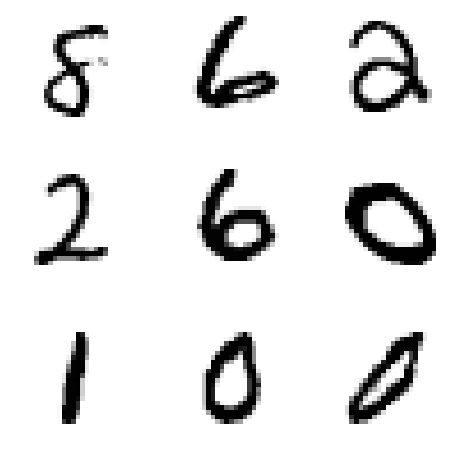

In [111]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().numpy(), cmap='Greys')
plt.show()

Модель

In [112]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [113]:
class CNN(nn.Module):
    def __init__(self, out_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, out_features)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [114]:
load_from_existing = False

In [115]:
number_of_labels = len(trainset.classes)
model = CNN(number_of_labels)

if load_from_existing:
    model.load_state_dict(torch.load('default_cnn.mdl'))
    print('loaded from previous save !!!')
model.to(device)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Навчання моделі

In [116]:
cross_el = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
epochs = 10

In [117]:
def evalute(model, loader):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
        correct += torch.eq(pred, y).sum().float().item()


    return correct / total

In [118]:
def train_model(train_dl, test_dl, model_name='model.mdl'):
    losses = []
    accuracy = []
    for epoch in range(epochs):
        epoch_losses=[]
        model.train()
        train_bar = tqdm(train_dl, file=sys.stdout)
        for data in train_bar:
            x, y = data
            output = model(x.to(device))
            loss = cross_el(output, y.to(device))
            epoch_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
        losses.append(np.mean(epoch_losses))
        if epoch % 1 == 0:  # You can change the validation frequency as you wish

            val_acc = evalute(model, test_dl)
            accuracy.append(val_acc)
            print('test_acc = ', val_acc)
        torch.save(model.state_dict(), model_name)
    return losses, accuracy

default_loss, default_accuracy = train_model(trainloader, testloader, 'default_cnn.mdl')

train epoch[1/10] loss:2.274:   1%|          | 38/3750 [00:00<00:20, 185.50it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


100%|██████████| 625/625 [00:02<00:00, 298.46it/s]
test_acc =  0.91
100%|██████████| 625/625 [00:02<00:00, 301.15it/s]
test_acc =  0.9392
100%|██████████| 625/625 [00:02<00:00, 298.51it/s]
test_acc =  0.9512
100%|██████████| 625/625 [00:02<00:00, 289.80it/s]
test_acc =  0.9599
100%|██████████| 625/625 [00:02<00:00, 295.70it/s]
test_acc =  0.9644
100%|██████████| 625/625 [00:02<00:00, 295.26it/s]
test_acc =  0.9679
100%|██████████| 625/625 [00:02<00:00, 296.26it/s]
test_acc =  0.9717
100%|██████████| 625/625 [00:02<00:00, 297.46it/s]
test_acc =  0.9745
100%|██████████| 625/625 [00:02<00:00, 297.12it/s]
test_acc =  0.9752
100%|██████████| 625/625 [00:02<00:00, 297.58it/s]
test_acc =  0.9771


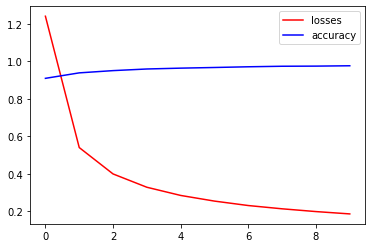

In [119]:
plt.plot(default_loss, label='losses',color='red')
plt.plot(default_accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

## Dropout реалізація

In [120]:
class CustomDropout(nn.Module):
    def __init__(self, p: float = 0.5):
        super(CustomDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, " "but got {}".format(p))
        self.p = p

    def forward(self, X):
        if self.training:
            binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
            return X * (binomial.sample(X.size()) * (1.0/(1-self.p))).to(device)
        return X

In [121]:
class CNNWithDropout(nn.Module):
    def __init__(self, out_features):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = CustomDropout(0.25)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, out_features)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [122]:
model = CNNWithDropout(number_of_labels)

if load_from_existing:
    model.load_state_dict(torch.load('dropout_cnn.mdl'))
    print('loaded from previous save !!!')
model.to(device)

CNNWithDropout(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): CustomDropout()
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [123]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
dropout_loss, dropout_accuracy = train_model(trainloader, testloader, 'dropout_cnn.mdl')

train epoch[1/10] loss:2.293:   0%|          | 2/3750 [00:00<05:14, 11.93it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


100%|██████████| 625/625 [00:02<00:00, 293.24it/s]
test_acc =  0.9058
100%|██████████| 625/625 [00:02<00:00, 295.66it/s]
test_acc =  0.9365
100%|██████████| 625/625 [00:02<00:00, 297.83it/s]
test_acc =  0.9514
100%|██████████| 625/625 [00:02<00:00, 285.74it/s]
test_acc =  0.961
100%|██████████| 625/625 [00:02<00:00, 294.82it/s]
test_acc =  0.9674
100%|██████████| 625/625 [00:02<00:00, 298.17it/s]
test_acc =  0.9708
100%|██████████| 625/625 [00:02<00:00, 298.81it/s]
test_acc =  0.976
100%|██████████| 625/625 [00:02<00:00, 295.83it/s]
test_acc =  0.9769
100%|██████████| 625/625 [00:02<00:00, 297.61it/s]
test_acc =  0.9782
100%|██████████| 625/625 [00:02<00:00, 288.52it/s]
test_acc =  0.9801


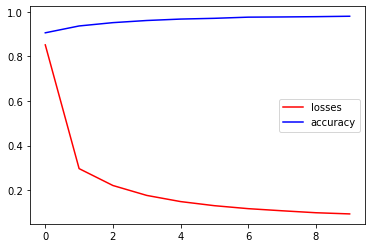

In [124]:
plt.plot(dropout_loss, label='losses',color='red')
plt.plot(dropout_accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

## Attention Layer реалізація

In [125]:
class AttentionBlock(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(AttentionBlock,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//2 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        B,C,W ,H = x.size()
        proj_query  = self.query_conv(x).view(B,-1,W*H).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(B,-1,W*H) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(B,-1,W*H) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(B,C,W,H)
        
        out = self.gamma*out + x
        return out,attention

In [126]:
class CNNWithAttention(nn.Module):
    def __init__(self, out_features):
        super(CNNWithAttention, self).__init__()
        # in: (1, 28, 28) , out: (10, 28, 28)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # in: (10, 14, 14) , out: (20, 14, 14)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, out_features)

        self.attention = AttentionBlock(10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x, attention = self.attention(x)
        x = F.relu(x)
  
        x = F.max_pool2d(self.conv2(x), 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [127]:
model = CNNWithAttention(number_of_labels)

if load_from_existing:
    model.load_state_dict(torch.load('attention_cnn.mdl'))
    print('loaded from previous save !!!')
model.to(device)

CNNWithAttention(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (attention): AttentionBlock(
    (query_conv): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
)

In [128]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
attention_loss, attention_accuracy = train_model(trainloader, testloader, 'attention_cnn.mdl')

train epoch[1/10] loss:2.302:   0%|          | 16/3750 [00:00<00:46, 79.59it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


100%|██████████| 625/625 [00:02<00:00, 266.93it/s]
test_acc =  0.9189
100%|██████████| 625/625 [00:02<00:00, 261.25it/s]
test_acc =  0.9432
100%|██████████| 625/625 [00:02<00:00, 267.21it/s]
test_acc =  0.9529
100%|██████████| 625/625 [00:02<00:00, 259.56it/s]
test_acc =  0.9612
100%|██████████| 625/625 [00:02<00:00, 265.04it/s]
test_acc =  0.9672
100%|██████████| 625/625 [00:02<00:00, 262.96it/s]
test_acc =  0.9702
100%|██████████| 625/625 [00:02<00:00, 264.13it/s]
test_acc =  0.975
100%|██████████| 625/625 [00:02<00:00, 268.15it/s]
test_acc =  0.9773
100%|██████████| 625/625 [00:02<00:00, 262.33it/s]
test_acc =  0.9793
100%|██████████| 625/625 [00:02<00:00, 253.96it/s]
test_acc =  0.98


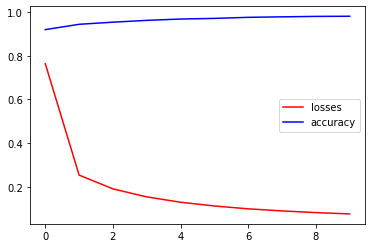

In [129]:
plt.plot(attention_loss, label='losses',color='red')
plt.plot(attention_accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

## Inseption Block

In [130]:
class InceptionBlock(nn.Module):
    def __init__(
        self, 
        in_channels, 
        out_1x1,
        red_3x3,
        out_3x3,
        red_5x5,
        out_5x5
    ):
        super(InceptionBlock, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_1x1, kernel_size=1),
            nn.ReLU()
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2),
            nn.ReLU()
        )
    
    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3)
        return torch.cat([branch(x) for branch in branches], 1)

In [131]:
class CNNInceptionBlock(nn.Module):
    def __init__(self, out_features):
        super(CNNInceptionBlock, self).__init__()
        # in: (1, 28, 28) , out: (10, 28, 28)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # in: (10, 14, 14) , out: (20, 14, 14)
        self.conv2 = InceptionBlock(10, 20, 15, 20, 10, 10)
        self.fc1 = nn.Linear(50*6*6, 50)
        self.fc2 = nn.Linear(50, out_features)


    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.max_pool2d(self.conv2(x), 2)

        x = F.relu(x)
        x = x.view(-1, 50*6*6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [132]:
model = CNNInceptionBlock(number_of_labels)

if load_from_existing:
    model.load_state_dict(torch.load('inception_cnn.mdl'))
    print('loaded from previous save !!!')
model.to(device)

CNNInceptionBlock(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): InceptionBlock(
    (branch1): Sequential(
      (0): Conv2d(10, 20, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(10, 15, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
  )
  (fc1): Linear(in_features=1800, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [133]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
inception_loss, inception_accuracy = train_model(trainloader, testloader, 'inception_cnn.mdl')

train epoch[1/10] loss:2.288:   1%|          | 29/3750 [00:00<00:26, 138.82it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


100%|██████████| 625/625 [00:02<00:00, 249.30it/s]
test_acc =  0.9347
100%|██████████| 625/625 [00:02<00:00, 245.74it/s]
test_acc =  0.954
100%|██████████| 625/625 [00:02<00:00, 261.45it/s]
test_acc =  0.9673
100%|██████████| 625/625 [00:02<00:00, 265.41it/s]
test_acc =  0.9729
100%|██████████| 625/625 [00:02<00:00, 261.44it/s]
test_acc =  0.9774
100%|██████████| 625/625 [00:02<00:00, 268.41it/s]
test_acc =  0.9785
100%|██████████| 625/625 [00:02<00:00, 261.81it/s]
test_acc =  0.9808
100%|██████████| 625/625 [00:02<00:00, 251.06it/s]
test_acc =  0.9813
100%|██████████| 625/625 [00:02<00:00, 264.35it/s]
test_acc =  0.9817
100%|██████████| 625/625 [00:02<00:00, 262.78it/s]
test_acc =  0.9837


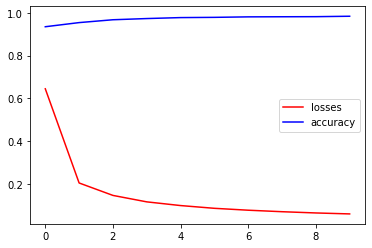

In [134]:
plt.plot(inception_loss, label='losses',color='red')
plt.plot(inception_accuracy, label= 'accuracy', color='blue')
plt.legend()
plt.show()

## Загальні результати 

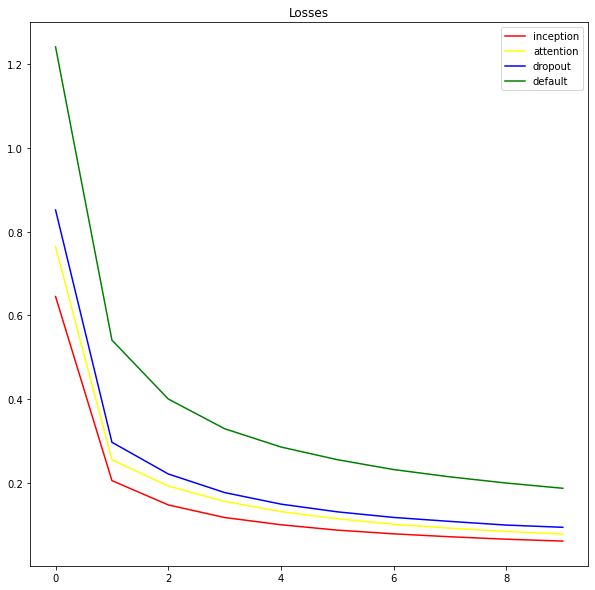

In [137]:
plt.figure(figsize=(10, 10))
plt.title('Losses')
plt.plot(inception_loss, label='inception',color='red')
plt.plot(attention_loss, label='attention',color='yellow')
plt.plot(dropout_loss, label='dropout',color='blue')
plt.plot(default_loss, label='default',color='green')
plt.legend()
plt.show()

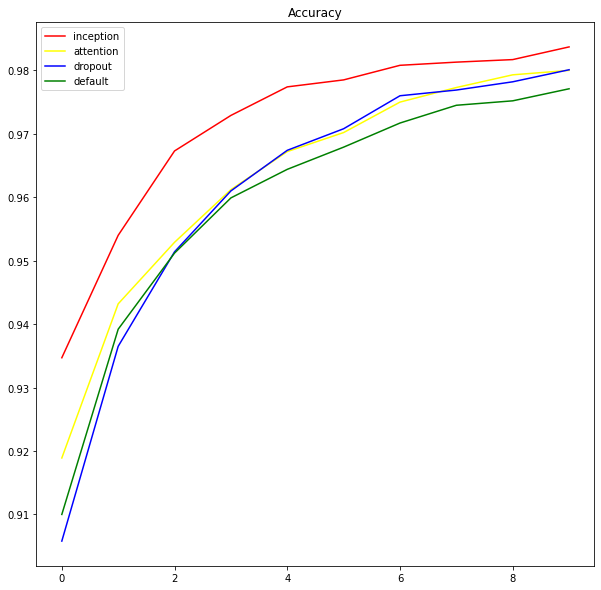

In [138]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')
plt.plot(inception_accuracy, label='inception',color='red')
plt.plot(attention_accuracy, label='attention',color='yellow')
plt.plot(dropout_accuracy, label='dropout',color='blue')
plt.plot(default_accuracy, label='default',color='green')
plt.legend()
plt.show()